# Time Series Analysis
**R. Gowri Lakshani**


In [5]:
# 1. Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch.unitroot import ADF
from statsmodels.tsa.statespace.tools import diff
from pmdarima.arima.utils import ndiffs
import pmdarima as pm
from statsmodels.stats.diagnostic import acorr_ljungbox
from pandas.tseries.offsets import MonthEnd
import statsmodels.api as sm


In [6]:
# 2. Import ‘USA Firm Sales’ data

csv_path = Path("USA_Firm_Sales_data.csv")
salesdata = pd.read_csv(csv_path)
salesdata.head()


,Year,Month,BU1,BU2,BU3
0,2015,February,125.1,115.5,113.8
1,2015,March,123.6,115.7,113.8
2,2015,April,123.1,116.5,114.0
3,2015,May,123.1,117.7,114.1
4,2015,June,123.4,118.3,114.7


In [7]:
salesdata.isna().sum()

Year     0
Month    0
BU1      0
BU2      0
BU3      0
dtype: int64

In [8]:
# 3. Converting Year and Month into a datetime index
salesdata['Date'] = pd.to_datetime(
    salesdata['Year'].astype(str) + ' ' + salesdata['Month'] + ' 1',
    format='%Y %B %d'
)
salesdata.set_index('Date', inplace=True)
salesdata.head()


,Year,Month,BU1,BU2,BU3
Date,,,,,
2015-02-01,2015,February,125.1,115.5,113.8
2015-03-01,2015,March,123.6,115.7,113.8
2015-04-01,2015,April,123.1,116.5,114.0
2015-05-01,2015,May,123.1,117.7,114.1
2015-06-01,2015,June,123.4,118.3,114.7


In [9]:
# 4. Create time series objects of the data.
rng = pd.date_range(start=salesdata.index.min(), periods=len(salesdata), freq='MS')

s_BU1 = salesdata.BU1.values
s_BU2 = salesdata.BU2.values
s_BU3 = salesdata.BU3.values

BU1_series = pd.Series(s_BU1, rng)
BU2_series = pd.Series(s_BU2, rng)
BU3_series = pd.Series(s_BU3, rng)

BU1_series.head()


2015-02-01    125.1
2015-03-01    123.6
2015-04-01    123.1
2015-05-01    123.1
2015-06-01    123.4
Freq: MS, dtype: float64

In [10]:
BU2_series.head()

2015-02-01    115.5
2015-03-01    115.7
2015-04-01    116.5
2015-05-01    117.7
2015-06-01    118.3
Freq: MS, dtype: float64

In [11]:
BU3_series.head()

2015-02-01    113.8
2015-03-01    113.8
2015-04-01    114.0
2015-05-01    114.1
2015-06-01    114.7
Freq: MS, dtype: float64

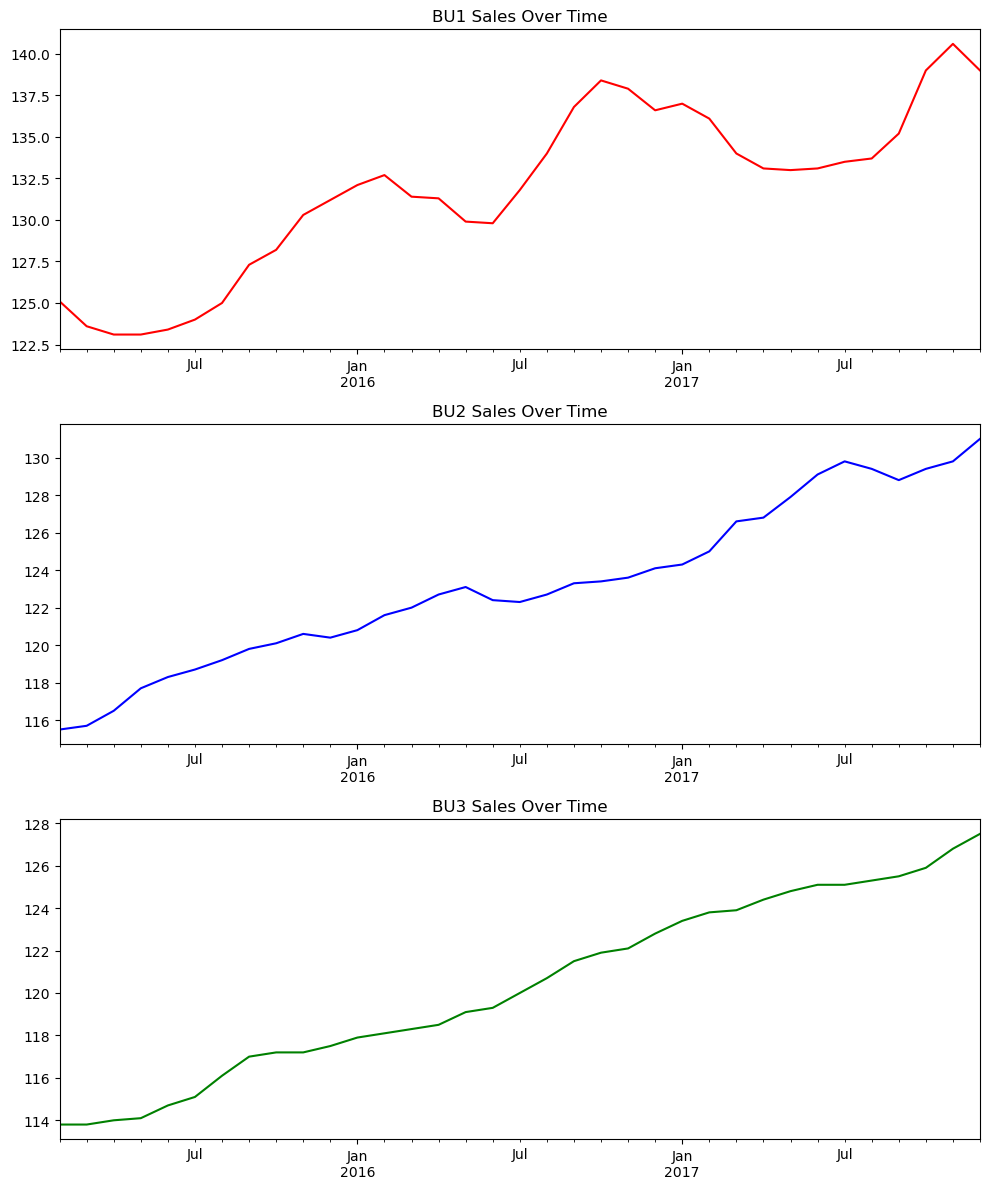

In [12]:
# 5. Check for stationarity for each of the three series.
# a) Plot time series

fig, axes = plt.subplots(3, 1, figsize=(10, 12))

BU1_series.plot(ax=axes[0], color='red', title="BU1 Sales Over Time")
BU2_series.plot(ax=axes[1], color='blue', title="BU2 Sales Over Time")
BU3_series.plot(ax=axes[2], color='green', title="BU3 Sales Over Time")

plt.tight_layout() 
plt.show()


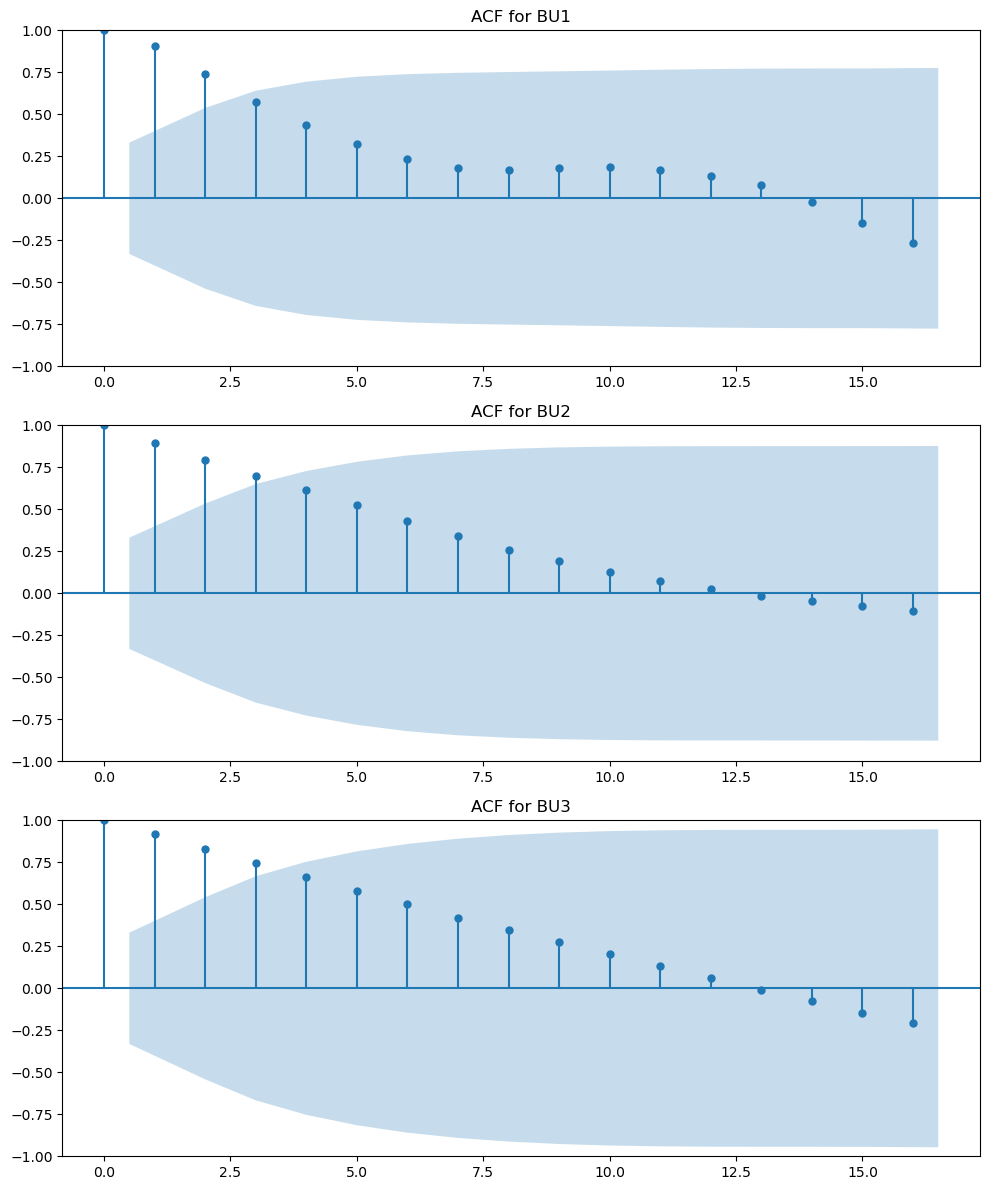

In [13]:
# b) Correlogram

fig, axes = plt.subplots(3, 1, figsize=(10, 12))

plot_acf(BU1_series, ax=axes[0])
axes[0].set_title("ACF for BU1")

plot_acf(BU2_series, ax=axes[1])
axes[1].set_title("ACF for BU2")

plot_acf(BU3_series, ax=axes[2])
axes[2].set_title("ACF for BU3")

plt.tight_layout()
plt.show()


In [14]:
# c) Dickey Fuller Test

adf_BU1 = ADF(BU1_series, lags=0, trend='n')
adf_BU1.summary()


Test Statistic,1.683
P-value,0.978
Lags,0


In [15]:
adf_BU2 = ADF(BU2_series, lags=0, trend='n')
adf_BU2.summary()


Test Statistic,5.295
P-value,1.000
Lags,0


In [16]:
adf_BU3 = ADF(BU3_series, lags=0, trend='n')
adf_BU3.summary()


Test Statistic,8.486
P-value,1.000
Lags,0


In [17]:
# How many times should each series be differenced to make it stationary?
diffs_BU1 = ndiffs(BU1_series)
diffs_BU2 = ndiffs(BU2_series)
diffs_BU3 = ndiffs(BU3_series)

print("No of differences needed for BU1:", diffs_BU1)
print("No of differences needed for BU2:", diffs_BU2)
print("No of differences needed for BU3:", diffs_BU3)


No of differences needed for BU1: 1
No of differences needed for BU2: 1
No of differences needed for BU3: 1


In [18]:
BU1_diff = diff(BU1_series)
BU2_diff = diff(BU2_series)
BU3_diff = diff(BU3_series)


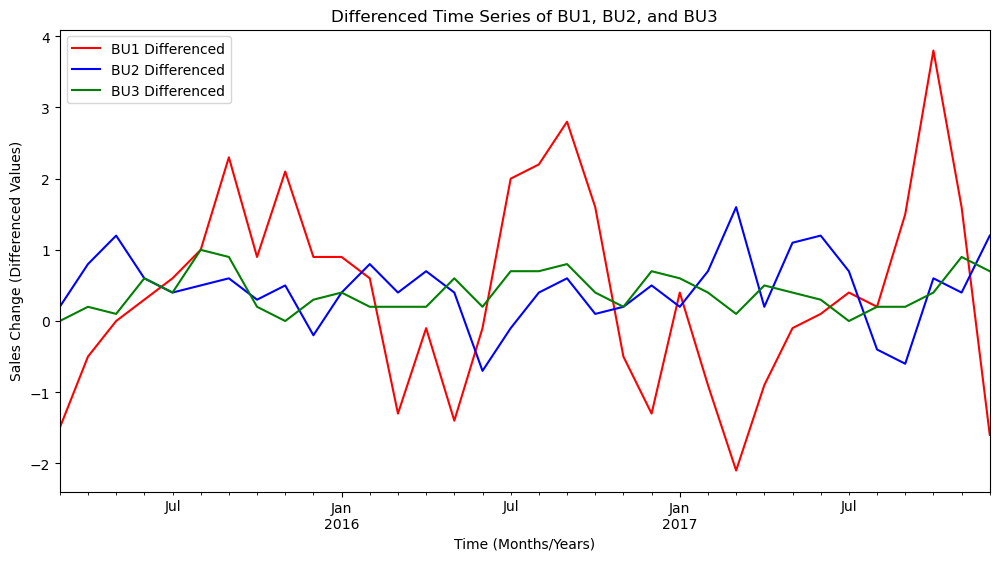

In [19]:
# Checking whether stationarity is achieved after differencing
# a) Differenced time series plots

fig, ax = plt.subplots(figsize=(12, 6))

pd.Series(BU1_diff, index=rng[1:]).plot(ax=ax, color='red', label='BU1 Differenced')
pd.Series(BU2_diff, index=rng[1:]).plot(ax=ax, color='blue', label='BU2 Differenced')
pd.Series(BU3_diff, index=rng[1:]).plot(ax=ax, color='green', label='BU3 Differenced')

ax.set_title("Differenced Time Series of BU1, BU2, and BU3")
ax.set_xlabel("Time (Months/Years)")
ax.set_ylabel("Sales Change (Differenced Values)")
ax.legend()

plt.show()


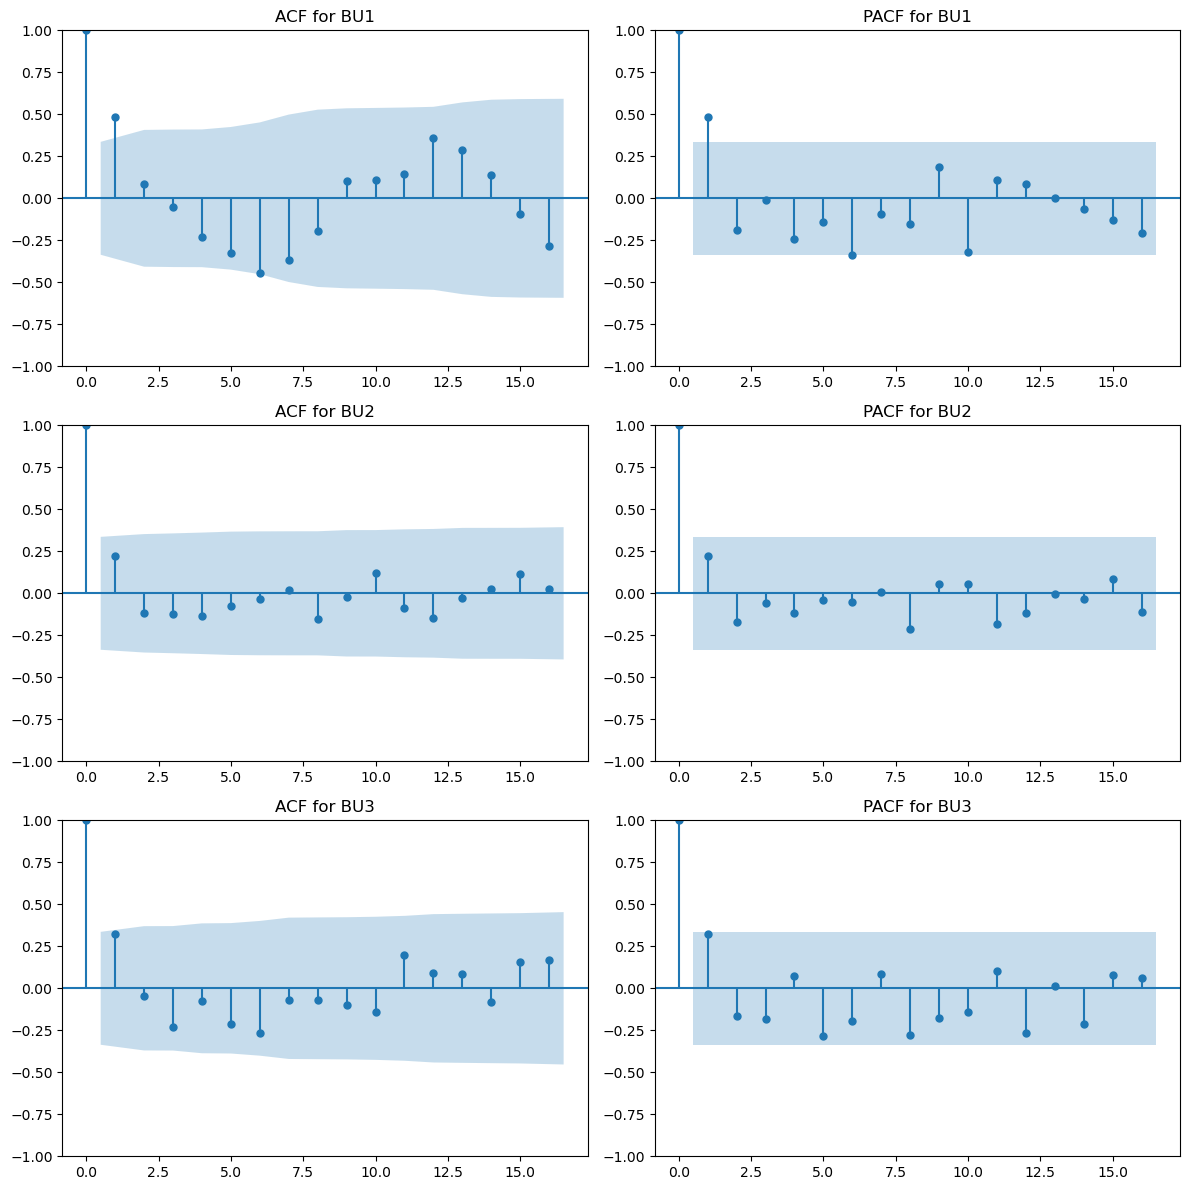

In [20]:
# b) ACF and PACF plots

fig, axes = plt.subplots(3, 2, figsize=(12, 12))

plot_acf(BU1_diff, ax=axes[0, 0])
axes[0, 0].set_title('ACF for BU1')

plot_pacf(BU1_diff, ax=axes[0, 1], method="ywm")
axes[0, 1].set_title('PACF for BU1')

plot_acf(BU2_diff, ax=axes[1, 0])
axes[1, 0].set_title('ACF for BU2')

plot_pacf(BU2_diff, ax=axes[1, 1], method="ywm")
axes[1, 1].set_title('PACF for BU2')

plot_acf(BU3_diff, ax=axes[2, 0])
axes[2, 0].set_title('ACF for BU3')

plot_pacf(BU3_diff, ax=axes[2, 1], method="ywm")
axes[2, 1].set_title('PACF for BU3')

plt.tight_layout()
plt.show()


In [21]:
# Dickey Fuller Test after differencing

BU1diff_adf = ADF(BU1_diff, lags=0, trend='n')
BU2diff_adf = ADF(BU2_diff, lags=0, trend='n')
BU3diff_adf = ADF(BU3_diff, lags=0, trend='n')

BU1diff_adf.summary()


Test Statistic,-2.963
P-value,0.003
Lags,0


In [22]:
BU2diff_adf.summary()

Test Statistic,-2.578
P-value,0.010
Lags,0


In [23]:
BU3diff_adf.summary()

Test Statistic,-1.615
P-value,0.100
Lags,0


In [24]:
# 6. Obtain best model for each BU (ARIMA via auto_arima)

BU1_model = pm.auto_arima(BU1_series, max_p=2, max_q=2, d=1, seasonal=False, trace=True)
BU2_model = pm.auto_arima(BU2_series, max_p=2, max_q=2, d=1, seasonal=False, trace=True)
BU3_model = pm.auto_arima(BU3_series, max_p=2, max_q=2, d=1, seasonal=False, trace=True)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=114.838, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=121.902, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=113.663, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=110.796, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=122.802, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=112.399, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=112.582, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=109.871, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=111.883, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=111.827, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=112.067, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=113.761, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.355 seconds
Performing stepwise search to minimize 

In [32]:
# Seasonal monthly ARIMA (m=12)
BU1_model_seasonal = pm.auto_arima(BU1_series, seasonal=True, m=12, d=1, trace=True)
BU2_model_seasonal = pm.auto_arima(BU2_series, seasonal=True, m=12, d=1, trace=True)
BU3_model_seasonal = pm.auto_arima(BU3_series, seasonal=True, m=12, d=1, trace=True)

print("BU1 seasonal:", BU1_model_seasonal)
print("BU2 seasonal:", BU2_model_seasonal)
print("BU3 seasonal:", BU3_model_seasonal)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=0.82 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=78.215, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=76.714, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=74.500, Time=0.11 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=73.767, Time=0.07 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=74.500, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=76.500, Time=0.12 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.15 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=76.954, Time=0.04 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=inf, Time=0.20 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   : AIC=75.364, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,1,0)[12]          
Total fit time: 2.039 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.77 sec
 ARIMA

In [25]:
# Diagnostic Checking

BU1_resi = pd.Series(BU1_model.resid(), rng)
acorr_ljungbox(BU1_resi, lags=None, boxpierce=True)


,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,0.009018,0.924344,0.008287,0.927467
2,0.009171,0.995425,0.008423,0.995797
3,0.010626,0.999710,0.009682,0.999747
4,0.010847,0.999985,0.009867,0.999988
5,0.011422,0.999999,0.010333,0.999999
6,0.011522,1.000000,0.010411,1.000000
7,0.013423,1.000000,0.011850,1.000000


In [26]:
BU2_resi = pd.Series(BU2_model.resid(), rng)
acorr_ljungbox(BU2_resi, lags=None, boxpierce=True)


,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,0.000342,0.985236,0.000315,0.985847
2,0.000508,0.999746,0.000462,0.999769
3,0.000910,0.999993,0.000810,0.999994
4,0.001485,1.000000,0.001291,1.000000
5,0.002405,1.000000,0.002038,1.000000
6,0.003346,1.000000,0.002775,1.000000
7,0.004322,1.000000,0.003514,1.000000


In [27]:
BU3_resi = pd.Series(BU3_model.resid(), rng)
acorr_ljungbox(BU3_resi, lags=None, boxpierce=True)


,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,0.000757,0.978052,0.000695,0.978961
2,0.000978,0.999511,0.000893,0.999554
3,0.002002,0.999976,0.001778,0.999980
4,0.002029,0.999999,0.001801,1.000000
5,0.003174,1.000000,0.002730,1.000000
6,0.003185,1.000000,0.002738,1.000000
7,0.003679,1.000000,0.003112,1.000000


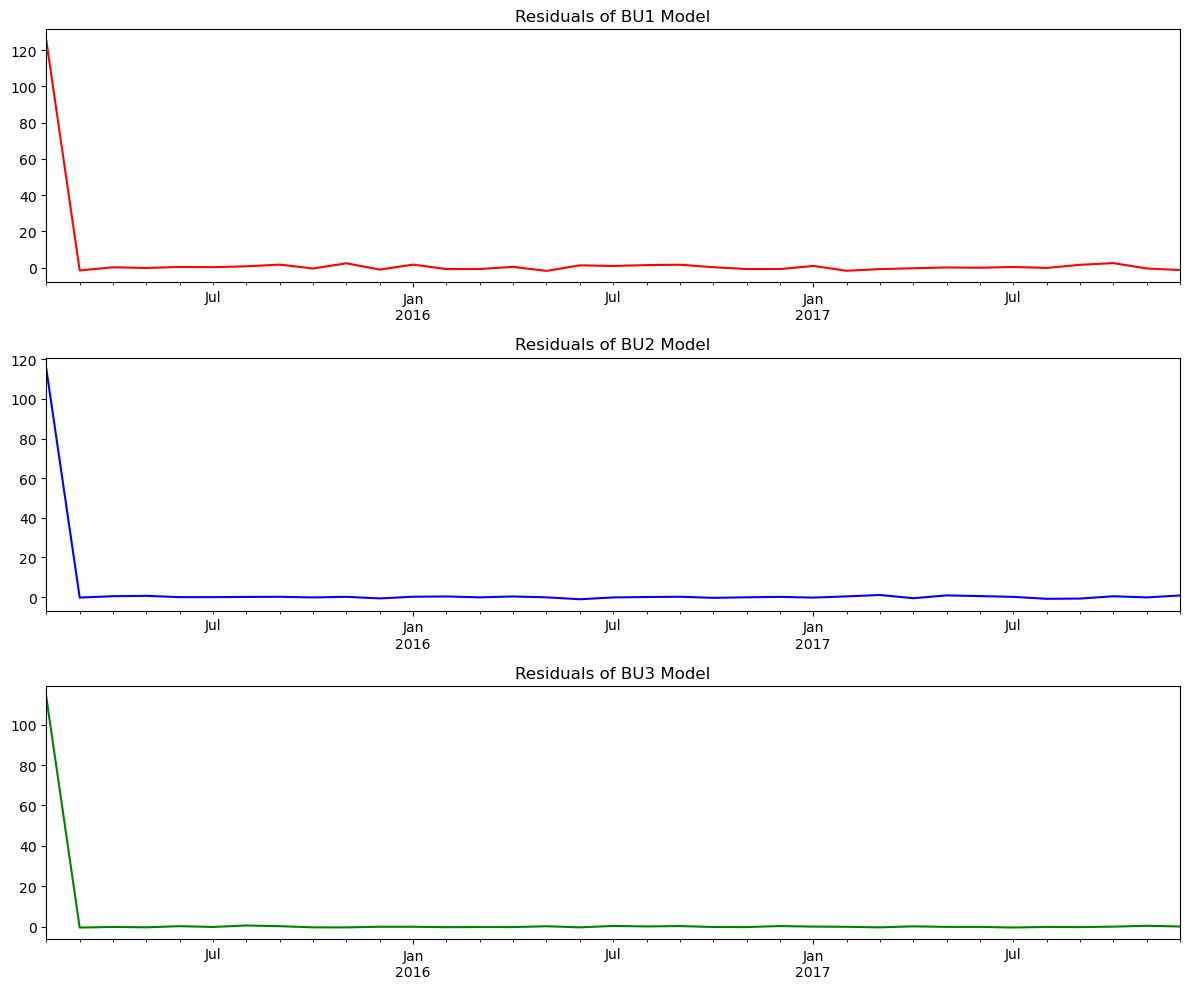

In [28]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

BU1_resi.plot(ax=axes[0], color='red')
axes[0].set_title("Residuals of BU1 Model")

BU2_resi.plot(ax=axes[1], color='blue')
axes[1].set_title("Residuals of BU2 Model")

BU3_resi.plot(ax=axes[2], color='green')
axes[2].set_title("Residuals of BU3 Model")

plt.tight_layout()
plt.show()


In [29]:
#7. Predict sales for each BU for Jan–Mar 2018 (3 months ahead)

BU1_forecast = BU1_model.predict(3)
BU2_forecast = BU2_model.predict(3)
BU3_forecast = BU3_model.predict(3)

BU1_forecast, BU2_forecast, BU3_forecast


(2018-01-01    137.98928
 2018-02-01    137.98928
 2018-03-01    137.98928
 Freq: MS, dtype: float64,
 2018-01-01    131.717876
 2018-02-01    132.178492
 2018-03-01    132.639109
 Freq: MS, dtype: float64,
 2018-01-01    127.947080
 2018-02-01    128.347705
 2018-03-01    128.748331
 Freq: MS, dtype: float64)

In [30]:
# Show as a clean table
forecast_table = pd.DataFrame({
    "BU1": BU1_forecast,
    "BU2": BU2_forecast,
    "BU3": BU3_forecast
}, index=["Jan 2018", "Feb 2018", "Mar 2018"])

forecast_table


,BU1,BU2,BU3
Jan 2018,137.98928,131.717876,127.947080
Feb 2018,137.98928,132.178492,128.347705
Mar 2018,137.98928,132.639109,128.748331
